In [130]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
import torch
import matplotlib.pyplot as plt

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [131]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
num_masses = 1
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

In [132]:
# [WALL]--(k0,b0)--[m0]--(k1,b1)--[m1]--(k2,b2)--[m2]

# Define system of equations
def multi_mass_spring_damper(y, t, m, k, b, F_ext=None):
    """
    y: concatenated [x0, x1, ..., xn, v0, v1, ..., vn]
    m, k, b: arrays of length n
    F_ext: optional external force per mass at time t
    """
    n = len(m)
    x = y[:n]
    v = y[n:]
    
    dxdt = v
    dvdt = np.zeros(n)

    for i in range(n):
        # External force
        F = 0
        if F_ext is not None:
            F = np.interp(t, t_data, F_ext[i])

        # F = np.interp(t, t_data, x_data[0, :, 0])

        # Spring-damper forces from neighbors
        force = 0

        # Left spring/damper: wall or previous mass
        if i == 0: 
         force += -k[0] * x[0] - b[0] * v[0]  # connected to wall
        else:
            force += -k[i] * (x[i] - x[i-1]) - b[i] * (v[i] - v[i-1])

        # Right spring/damper: next mass if not last
        if i < n - 1:
            force += -k[i+1] * (x[i] - x[i+1]) - b[i+1] * (v[i] - v[i+1])

        dvdt[i] = (F + force) / m[i]

    return np.concatenate([dxdt, dvdt])


def multi_msd_simulator(params, F_ext=None):
    """
    params: [m0, m1, ..., k0, k1, ..., b0, b1, ...]
    """
    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return extract_summary_statistics_multimass(t, x, v)

def multi_msd_simulator_raw(params, F_ext=None):

    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return t, x, v


def extract_summary_statistics_multimass(t, x, v):
    num_masses = x.shape[1]

    # Compute stats per mass
    stats = []
    for i in range(num_masses):
        stats.extend(extract_summary_statistics(t, x[:, i], v[:, i]))

    return np.array(stats)


def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

def generate_deterministic_force(timesteps, num_masses, seed=42, smoothing=2.0):
    rng = np.random.default_rng(seed)
    raw = rng.random(timesteps) - 0.5
    force = np.cumsum(raw)
    force = gaussian_filter1d(force, sigma=smoothing)
    force = np.abs(force)
    return np.tile(force, (num_masses, 1)) 

def generate_stochastic_force(timesteps, num_masses, seed=None, smoothing=1.5):
    rng = np.random.default_rng(seed)
    # Random walk force signal
    F_shared = np.abs(np.cumsum(rng.random(timesteps) - 0.5))
    # Optional smoothing
    if smoothing is not None and smoothing > 0:
        F_shared = gaussian_filter1d(F_shared, sigma=smoothing)
    # Tile for each mass
    return np.tile(F_shared, (num_masses, 1))

def simulator(params):

    F_ext = generate_stochastic_force(num_timesteps, num_masses)

    # F_ext = generate_deterministic_force(num_timesteps, num_masses)

    # F_ext = np.abs(np.cumsum(np.random.rand(num_masses, num_timesteps) - 0.5, axis=1))

    return multi_msd_simulator(params, F_ext=F_ext)

In [133]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
num_params = 3 * num_masses 

prior = sbi_utils.BoxUniform(
    low=torch.tensor([0.1] * num_params),
    high=torch.tensor([10.0] * num_params)
)

prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    simulator,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)

# Create inference object
inference = NPE(prior)

In [ ]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [135]:
# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 327 epochs.

In [136]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

In [137]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

sample = prior.sample((1,))
observed_data = simulator(sample.numpy()[0])
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((100000,), x=observed_data)
params, labels = get_param_labels_and_values(samples, num_masses)
for i, label in enumerate(labels):
    print(f"T {label}: {sample[0][i]:.4f}, I {label}: {params[i]:.4f}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

T m0: 5.6747, I m0: 1.1807
T k0: 3.8337, I k0: 5.0583
T b0: 5.9278, I b0: 8.9648


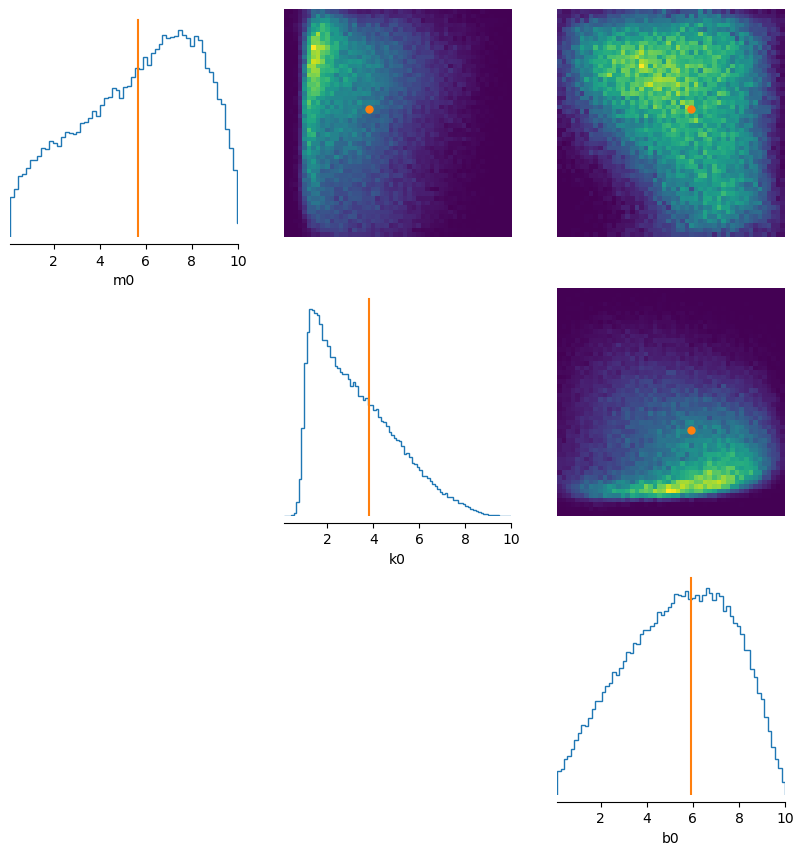

In [138]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples,
    points=sample,
    labels=labels,
    limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
)

In [139]:
def plot_posterior_prediction_band(
    posterior,
    x_o,
    simulator_raw,
    force_func,
    mass_index=0,
    num_samples=100,
    show_samples=False,
    plot_position=True,
    plot_velocity=True,
    color='C0',
    label='Posterior Predictive'
):
    """
    Plots posterior predictive uncertainty bands for position and/or velocity
    of a selected mass in a multi-mass system.

    Parameters:
        posterior: Trained SBI posterior
        x_o: Observation used for conditioning
        simulator_raw: Function returning t, x, v
        force_func: Callable that returns the external force
        mass_index: Index of mass to plot (e.g., 0 for x_0, v_0)
        num_samples: Number of posterior samples to draw
        show_samples: Whether to plot all sampled trajectories
        plot_position: Whether to plot position
        plot_velocity: Whether to plot velocity
        color: Color of the predictive band and lines
        label: Label for the legend
    """
    x_trajectories = []
    v_trajectories = []
    t_ref = None

    theta_samples = theta_sample = posterior.sample((num_samples,), x=x_o).numpy().squeeze()
    for theta_sample in theta_samples:
        t, x, v = simulator_raw(theta_sample, force_func())
        if t_ref is None:
            t_ref = t
        x_trajectories.append(x[:, mass_index])
        v_trajectories.append(v[:, mass_index])

    x_trajectories = np.stack(x_trajectories)
    v_trajectories = np.stack(v_trajectories)

    if plot_position:
        lower_x = np.percentile(x_trajectories, 5, axis=0)
        upper_x = np.percentile(x_trajectories, 95, axis=0)
        median_x = np.median(x_trajectories, axis=0)

        plt.fill_between(t_ref, lower_x, upper_x, color=color, alpha=0.3, label=f'{label} $x_{mass_index}$ (90% CI)')
        plt.plot(t_ref, median_x, color=color, lw=2, label=f'{label} $x_{mass_index}$ (Median)')

        if show_samples:
            for traj in x_trajectories:
                plt.plot(t_ref, traj, color=color, alpha=0.1, lw=0.8)

    if plot_velocity:
        lower_v = np.percentile(v_trajectories, 5, axis=0)
        upper_v = np.percentile(v_trajectories, 95, axis=0)
        median_v = np.median(v_trajectories, axis=0)

        plt.fill_between(t_ref, lower_v, upper_v, color='C1', alpha=0.3, label=f'{label} $v_{mass_index}$ (90% CI)')
        plt.plot(t_ref, median_v, color='C1', lw=2, label=f'{label} $v_{mass_index}$ (Median)')

        if show_samples:
            for traj in v_trajectories:
                plt.plot(t_ref, traj, color='C1', alpha=0.1, lw=0.8)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

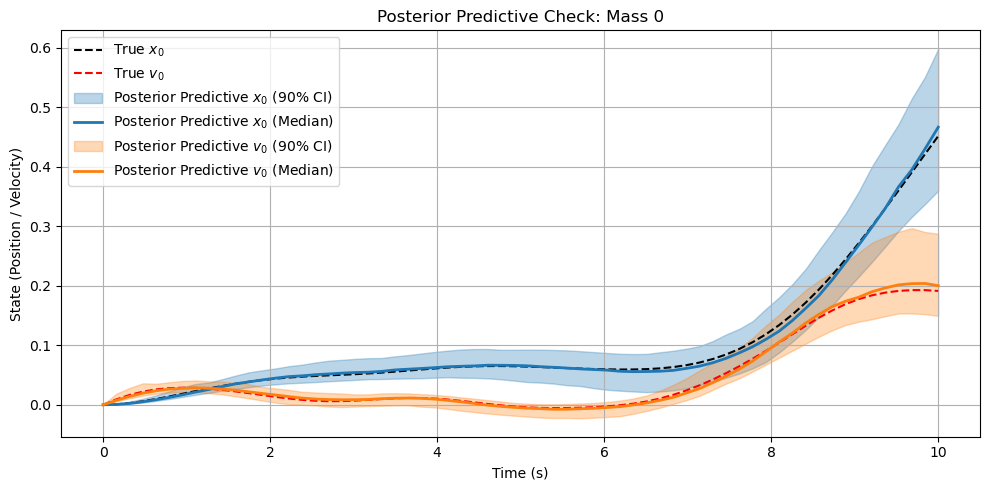

In [140]:
# Ground truth trajectory
force_func = generate_stochastic_force(num_timesteps, num_masses)
true_params = sample.flatten()
t_real, x_real, v_real = multi_msd_simulator_raw(true_params, force_func)
x_o = extract_summary_statistics_multimass(t_real, x_real, v_real)

# Plot
plt.figure(figsize=(10, 5))

# True trajectories
plt.plot(t_real, x_real[:, 0], '--k', label='True $x_0$')
plt.plot(t_real, v_real[:, 0], '--r', label='True $v_0$')

# Posterior predictions
plot_posterior_prediction_band(
    posterior,
    x_o,
    simulator_raw=multi_msd_simulator_raw,
    force_func=lambda: force_func,
    mass_index=0,
    num_samples=100,
    plot_position=True,
    plot_velocity=True,
    show_samples=False
)

plt.xlabel("Time (s)")
plt.ylabel("State (Position / Velocity)")
plt.title("Posterior Predictive Check: Mass 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()